# Projet Deep Learning II
## Mise en œuvre de RBM, DBN et DNN
## Professeur: Yohan Petetin

Auteurs: SOW Babacar, Mohamed Farhat, Abdelmouaiz Tebjou

## Partie I: Introduction

Dans ce projet, nous avons implémenté 3 modèles d'apprentissage profond: RBM, DBN et DNN. L'ouvrage est divisé en 3 parties. Le premier concerne la mise en œuvre des classes RBM, DBN et DNN. Nous testons ensuite nos algorithmes dans la deuxième partie, principalement leur capacité d'apprentissage et leur capacité à générer des données. Nous terminons en comparant les performances d'un DNN de classification sur le jeu de données MNIST avec / sans pré-apprentissage.

## Partie II: Algorithmes
Dans cette partie, nous implémentons les différentes structures que nous avons mentionnées sous forme de classes.

Nous importons tous les packages nécessaires au projet.

In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

###  Lecture des données et fonctions préliminaires

Obtenir le jeu de données mnist pour les parties ultérieures.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz") #Importing the MNIST dataset

La fonction suivante renvoie l'ordre d'un caractère dans le jeu de données Binary Alpha Digit.

In [3]:
def to_num(alpha):
    if ord(alpha) >= 65:
        return ord(alpha)-55
    else :
        return ord(alpha)-48

La fonction $\textbf{lire_alpha_digit}$, récupère les images des caractères spécifiés à apprendre, les met sous la forme d'une ligne et retourne une matrice des données où les lignes sont les données et les colonnes représentent les pixels.

In [82]:
def lire_alpha_digit(path, strSlct, nb_expl = 39):
    data = sio.loadmat(path)
    snip = None
    if isinstance(strSlct, str):
        for datum in strSlct:
            ind = to_num(datum)
            temp = np.concatenate(data['dat'][ind, 0:nb_expl], axis=1).flatten(order='F').reshape(320, nb_expl, order='F')
            if snip is not None:
                snip = np.hstack((snip, temp))
            else :
                snip = temp
    return snip.T

### Classe RBM
La classe suivante implémente une structure RBM.

Description de la classe: 
- La méthode $\textbf{init}$ initialise une structure RBM avec des poids aléatoires et des biais nuls.
- La fonction $\textbf{entree_sortie_RBM}$ fait le passage en avant des données et renvoie les probabilités et les données.
- La fonction $\textbf{sortie_entree_RBM}$ effectue le retour arrière des données et renvoie les probabilités et les données.
- La fonction $\textbf{train_RBM}$ entraîne le RBM à l'aide de l'algorithme de divergence contrastive.
- La fonction $\textbf{generer_image_RBM}$ générer des images à l'aide du RBM entraîné et de l'algorithme d'échantillonnage de Gibbs.

In [127]:
class RBM:
    
    def __init__(self, nb_v, nb_h):
        self.bias_a = np.zeros((1, nb_v))
        self.bias_b = np.zeros((1, nb_h))
        self.weights = 1e-1*np.random.randn(nb_v, nb_h)
        
    def sigmoid(self, data):
        return 1/(1+np.exp(-1*data))
    
    def softmax(self, data):
        return np.exp(data)/np.sum(np.exp(data), axis=1).reshape(-1, 1)

    def entree_sortie_RBM(self, v, act='sigmoid'):
        
        if act=='sigmoid':
            prob_h =  self.sigmoid(self.bias_b + v@self.weights)
        else:
            prob_h =  self.softmax(self.bias_b + v@self.weights)
        h = (np.random.uniform(0, 1, size=prob_h.shape) < prob_h) * 1
        
        return h, prob_h
    
    def sortie_entree_RBM(self, h, act='sigmoid'):
        
        if act=='sigmoid':
            prob_v =  self.sigmoid(self.bias_a + h@self.weights.T)
        else:
            prob_v =  self.softmax(self.bias_a + h@self.weights.T)
            
        v = (np.random.uniform(0, 1, size=prob_v.shape) < prob_v) * 1
        
        return v, prob_v
    
    def train_RBM(self, data, batch_size=50, n_epoch=10000, lr_rate=0.01, verbose=True):
        
        assert n_epoch > 0
        batch_size = batch_size if batch_size <= data.shape[1] else data.shape[1]
        
        for i in range(n_epoch):
            batch = data[np.random.choice(np.arange(data.shape[0]), batch_size), :]
            # Contrastive divergence (type I) 
            h_0, prob_h_0 = self.entree_sortie_RBM(batch)
            v_1, prob_v_1 = self.sortie_entree_RBM(h_0)
            h_1, prob_h_1 = self.entree_sortie_RBM(v_1)
            grad_a, grad_b = np.mean(batch - v_1, axis=0), np.mean(prob_h_0 - prob_h_1, axis=0)
            grad_weights = batch.T@prob_h_0 - v_1.T@prob_h_1
            self.bias_a += lr_rate*grad_a.reshape(1, -1)
            self.bias_b += lr_rate*grad_b.reshape(1, -1)
            self.weights += lr_rate/batch_size*grad_weights
            
            if verbose==True and i%1000==0:
                print("Iteration %d out of %d. Loss value is %.4f" %(i, n_epoch, 
                    np.sum((batch - v_1)**2)/batch_size))
                
        return self

    def generer_image_RBM(self, data_shape, nb_images=10, rows=20, cols=16, figsize=(8,6), max_iter=10000):
        
        data = np.random.rand(nb_images, data_shape)
        
        # Gibbs sampling
        for j in range(max_iter):
            data, _ = self.entree_sortie_RBM(data)
            data, _ = self.sortie_entree_RBM(data)
            
        im_cols = 3
        im_rows = nb_images // im_cols + nb_images % im_cols
        position = range(1,nb_images + 1)
        fig = plt.figure(1, figsize=figsize)
        
        for k in range(nb_images):
            ax = fig.add_subplot(im_rows, im_cols, position[k])
            ax.imshow(data[k, :].reshape(rows, cols, order='F'), cmap='gray')  
            
        return data

### Classe DBN
La classe suivante implémente une structure DBN.

Description de la classe: 
- La méthode $\textbf{init}$ initialise un réseau DBN. Le DBN a un attribut qui est une liste de RBM qui sont initialisés selon le méthoïde init de la classe RBM.
- La fonction $\textbf{pretrain_DNN}$ entraîne 'greedly' le DBN, couche par couche en utilisant l'algorithme de divergence contrastive pour chaque couche.
- La fonction $\textbf{generer_image_DBN}$ générer des images à l'aide du DBN pré-entraîné et de l'algorithme d'échantillonnage de Gibbs.

In [151]:
class DNN :
    
    def __init__(self, n_layers):
        self.RBM_list = [RBM(lyr_prd, lyr_nxt) for lyr_prd, lyr_nxt in zip(n_layers, n_layers[1:])]
        
    def pretrain_DNN(self, data, batch_size=50, n_epoch=10000, lr_rate=0.01, verbose=True):
        for ind, rbm in enumerate(self.RBM_list):
            print('Training layer ', ind)
            rbm = rbm.train_RBM(data, batch_size=batch_size, n_epoch=n_epoch, lr_rate=lr_rate, verbose=verbose)
            _, data  = rbm.entree_sortie_RBM(data)
        return self
    
    def generer_image_DBN(self, data_shape, nb_images=10, rows=20, cols=16, figsize=(8,6), max_iter=10000):
        
        data = np.random.binomial(1, 0.5, size=(nb_images, data_shape))
        
        for itr in range(max_iter):
            for rbm in self.RBM_list[:-1]:
                data, _ = rbm.entree_sortie_RBM(data)
                
            data, _ = self.RBM_list[-1].entree_sortie_RBM(data)
            
            for rbm in reversed(self.RBM_list[1:]):
                _, data= rbm.sortie_entree_RBM(data)
                
            data, _ = self.RBM_list[0].sortie_entree_RBM(data)
                
        im_cols = 3
        im_rows = nb_images // im_cols + nb_images % im_cols
        position = range(1,nb_images + 1)
        fig = plt.figure(1, figsize=figsize)
        for k in range(nb_images):
            ax = fig.add_subplot(im_rows, im_cols, position[k])
            ax.imshow(data[k, :].reshape(rows, cols, order='F'), cmap='gray')      
        return data

### Classe MNIST DNN
La classe suivante implémente une structure DNN.

Description de la classe: 
- La méthode $\textbf{init}$ initialise un DNN comme dans la classe DBN.
- La fonction $\textbf{calcul_softmax}$ calcule les probabilités sur les unités de sortie à l'aide de la fonction softmax.
- La fonction $\textbf{entree_sortie_reseau}$ calcule la valeur des unités de sortie du DNN et les stocke dans une liste.
- La fonction $\textbf{retropropagation}$ entraîne le DNN à l'aide de l'algorithme de rétropropagation (entraîner le réseau de manière supervisée).
- La fonction $\textbf{test_dnn}$ calcule le pourcentage d'étiquettes mal classées en utilisant un DNN.

In [162]:
class MNIST_DNN(DNN):
    
    def __init__(self, n_layers):
        super().__init__(n_layers)
        
    def calcul_softmax(self, rbm_struct, data_in):
        _, h_p = rbm_struct.entree_sortie_RBM(data_in, act='softmax')
        return h_p
        
    def entree_sortie_reseau(self, data_in):
        outputs = [data_in]
        for rbm in self.RBM_list[:-1]:
            _ , data_in = rbm.entree_sortie_RBM(data_in)
            outputs.append(data_in)
        outputs.append(self.calcul_softmax(self.RBM_list[-1], data_in))
        return outputs
    
    def retropropagation(self, data, labels, batch_size=50, n_epoch=10000, lr_rate=0.01, verbose=True):
        assert n_epoch > 0
        batch_size = batch_size if batch_size <= data.shape[1] else data.shape[1]
        for i in range(n_epoch):
            batch_idx = np.random.choice(np.arange(data.shape[0]), batch_size)
            batch = data[batch_idx]
            batch_labels = labels[batch_idx]
            outputs = self.entree_sortie_reseau(batch)
            rbm = self.RBM_list[-1]
            c = (outputs[-1]-batch_labels)
            rbm.weights -= lr_rate/batch_size * outputs[-2].T @ c 
            rbm.bias_b -= lr_rate * np.mean(c, axis = 0) 
            for idx, rbm in reversed(list(enumerate(self.RBM_list[:-1]))):
                c = c@self.RBM_list[idx+1].weights.T*outputs[idx+1]*(1-outputs[idx+1])
                rbm.weights -= lr_rate/batch_size * outputs[idx].T @ c 
                rbm.bias_b -= lr_rate * np.mean(c, axis=0) 
            if verbose==True and i%1000==0:
                print("Iteration %d out of %d. CELoss value is %.4f" %(i, n_epoch,
                                                                -np.sum(batch_labels*np.log(outputs[-1]))/batch_size))
        return self
    
    def test_dnn(self, data, labels):
        for rbm in self.RBM_list[:-1]:
            _  ,  data = rbm.entree_sortie_RBM(data)
        preds = np.argmax(self.calcul_softmax(self.RBM_list[-1], data), axis=1)
        good_labels = 0
        for idx, pred in enumerate(preds):
            if pred==labels[idx]:
                good_labels+=1
        print("The percentage of false labeled data is ", 100*(labels.shape[0]-good_labels)/labels.shape[0])
        return 100*(labels.shape[0]-good_labels)/labels.shape[0]
        

## Partie III: Test du RBM et du DBN

Dans cette partie, nous testons dans quelle mesure le RBM et le DBN sont capables d'apprendre et de générer des échantillons qui ressemblent aux données.

### Test du RBM sur l'ensemble de données alphadigit

#### Entraînement du réseau

In [134]:
to_learn_chrs = "842CDF" # Characters that we want to learn
data = lire_alpha_digit("./data/binaryalphadigs.mat", to_learn_chrs) # Getting the data
alpha_rbm = RBM(data[0, :].shape[0], 250) # Constructing an RBM class instance
alpha_rbm =  alpha_rbm.train_RBM(data, n_epoch=50000, verbose=True) # Training the RBM

Iteration 0 out of 50000. Loss value is 146.4800
Iteration 1000 out of 50000. Loss value is 62.1800
Iteration 2000 out of 50000. Loss value is 46.9000
Iteration 3000 out of 50000. Loss value is 38.2600
Iteration 4000 out of 50000. Loss value is 30.9800
Iteration 5000 out of 50000. Loss value is 27.8600
Iteration 6000 out of 50000. Loss value is 23.3400
Iteration 7000 out of 50000. Loss value is 19.9600
Iteration 8000 out of 50000. Loss value is 18.1000
Iteration 9000 out of 50000. Loss value is 16.4800
Iteration 10000 out of 50000. Loss value is 15.1000
Iteration 11000 out of 50000. Loss value is 12.7600
Iteration 12000 out of 50000. Loss value is 12.5000
Iteration 13000 out of 50000. Loss value is 11.5600
Iteration 14000 out of 50000. Loss value is 10.4200
Iteration 15000 out of 50000. Loss value is 9.7200
Iteration 16000 out of 50000. Loss value is 7.9200
Iteration 17000 out of 50000. Loss value is 8.4000
Iteration 18000 out of 50000. Loss value is 7.2800
Iteration 19000 out of 50000

#### Générer des échantillons d'images

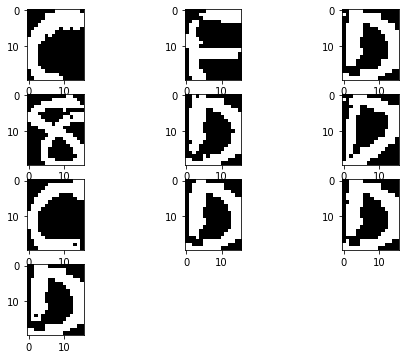

In [136]:
generated = alpha_rbm.generer_image_RBM(data[0, :].shape[0], 10, max_iter=30000)

### Test du DBN sur l'ensemble de données alphadigit

#### Entraînement du réseau

In [137]:
to_learn_chrs = "524ABN"
data = lire_alpha_digit("./data/binaryalphadigs.mat", to_learn_chrs)
layers = [data[0, :].shape[0], 300, 250, 200, 150, 100]
alpha_dbn = DNN(layers)
alpha_dbn =  alpha_dbn.pretrain_DNN(data, n_epoch=20000, verbose=True)

Training layer  0
Iteration 0 out of 20000. Loss value is 143.6800
Iteration 1000 out of 20000. Loss value is 59.5200
Iteration 2000 out of 20000. Loss value is 43.4000
Iteration 3000 out of 20000. Loss value is 37.1400
Iteration 4000 out of 20000. Loss value is 29.8200
Iteration 5000 out of 20000. Loss value is 26.6200
Iteration 6000 out of 20000. Loss value is 21.3200
Iteration 7000 out of 20000. Loss value is 19.5200
Iteration 8000 out of 20000. Loss value is 17.0600
Iteration 9000 out of 20000. Loss value is 14.6400
Iteration 10000 out of 20000. Loss value is 12.9600
Iteration 11000 out of 20000. Loss value is 11.7800
Iteration 12000 out of 20000. Loss value is 8.9200
Iteration 13000 out of 20000. Loss value is 9.2000
Iteration 14000 out of 20000. Loss value is 8.5800
Iteration 15000 out of 20000. Loss value is 8.0200
Iteration 16000 out of 20000. Loss value is 6.8800
Iteration 17000 out of 20000. Loss value is 7.4400
Iteration 18000 out of 20000. Loss value is 6.8400
Iteration 190

#### Générer des échantillons d'images

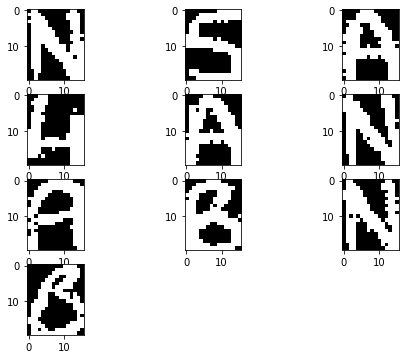

In [139]:
generated = alpha_dbn.generer_image_DBN(data[0, :].shape[0], 10, max_iter=15000)

## Partie IV: Etude sur le jeu de données MNIST

Dans cette partie, nous étudions comment le pré-entraînement affecte le pouvoir de classification d'un DNN. Nous comparerons deux DNN, dans divers contextes, et verrons comment ils fonctionnent en conséquence.

### Fonctions préliminaires

La première fonction, $\textbf{scale_and_read_img}$, lit les données (images) puis les transforme en une matrice où chaque ligne est une instance de données et les colonnes représentent des pixels. Il met ensuite les valeurs à l'échelle pour qu'elles soient dans la plage $[0, 1
]$. La deuxième fonction $\textbf{transform_labels}$ transforme les étiquettes en code one_hot.

In [140]:
def scale_and_read_img(data_set):
    snip = None
    data_std = (data_set - np.min(data_set))/(np.max(data_set) - np.min(data_set))
    for datum in data_std:
        temp = datum.flatten(order='F')
        if snip is not None:
            snip = np.vstack((snip, temp))
        else :
            snip = temp
    return snip

def transform_labels(labels):
    output = np.zeros((labels.shape[0], 10))
    for idx, label in enumerate(labels):
        output[idx, label] = 1
    return output

Chargement des données

In [154]:
data_mnist = scale_and_read_img(x_train)
#data_mnist = np.load('./mnist-data.npy') # We stored the transfromed data in a npy format because transforming takes a lot of time
test_data = scale_and_read_img(x_test) # scaling test data
labels = transform_labels(y_train) #transforming labels

### Entraînemen d'un DNN et génération d'échantillons

In [197]:
layers = [data[0, :].shape[0], 700, 600, 500, 400, 300, 200, 100, 50, 10]
test_dnn = MNIST_DNN(layers)
print('begin unsupervised training')
test_dnn = test_dnn.pretrain_DNN(data_mnist, batch_size=150, n_epoch=15000)
print('Unsupervised training is done')

print('begin supervised training')
test_dnn = test_dnn.retropropagation(data_mnist, labels, lr_rate=0.1, batch_size=150, n_epoch=30000)
print('Supervised training is done')

begin unsupervised training
Training layer  0
Iteration 0 out of 15000. Loss value is 360.9308
Iteration 1000 out of 15000. Loss value is 51.6282
Iteration 2000 out of 15000. Loss value is 44.0541
Iteration 3000 out of 15000. Loss value is 44.6145
Iteration 4000 out of 15000. Loss value is 41.5751
Iteration 5000 out of 15000. Loss value is 40.0454
Iteration 6000 out of 15000. Loss value is 39.5028
Iteration 7000 out of 15000. Loss value is 36.2359
Iteration 8000 out of 15000. Loss value is 37.3676
Iteration 9000 out of 15000. Loss value is 34.1671
Iteration 10000 out of 15000. Loss value is 36.1367
Iteration 11000 out of 15000. Loss value is 32.1605
Iteration 12000 out of 15000. Loss value is 34.3805
Iteration 13000 out of 15000. Loss value is 34.3076
Iteration 14000 out of 15000. Loss value is 33.4376
Training layer  1
Iteration 0 out of 15000. Loss value is 265.9185
Iteration 1000 out of 15000. Loss value is 109.7325
Iteration 2000 out of 15000. Loss value is 100.1080
Iteration 3000 

Iteration 20000 out of 30000. CELoss value is 0.0844
Iteration 21000 out of 30000. CELoss value is 0.0544
Iteration 22000 out of 30000. CELoss value is 0.0426
Iteration 23000 out of 30000. CELoss value is 0.0311
Iteration 24000 out of 30000. CELoss value is 0.0127
Iteration 25000 out of 30000. CELoss value is 0.0425
Iteration 26000 out of 30000. CELoss value is 0.0543
Iteration 27000 out of 30000. CELoss value is 0.1025
Iteration 28000 out of 30000. CELoss value is 0.0087
Iteration 29000 out of 30000. CELoss value is 0.0145
Supervised training is done


AttributeError: 'MNIST_DNN' object has no attribute 'test'

In [198]:
test_dnn.test_dnn(test_data, y_test)

The percentage of false labeled data is  2.57


2.57

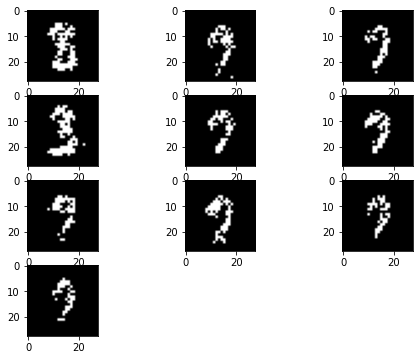

In [200]:
generated = test_dnn.generer_image_DBN(data_mnist[0, :].shape[0], 10, rows=28, cols=28, max_iter=15000)

Le réseau semble générer des formes de 3, 8 et 9 de plus que celles des autres échantillons.

### L'effet du nombre de couches sur la classification

Dans cette expérience, nous utiliserons deux DNN de même taille, l'un avec pré-entraînement et l'autre sans  pré-entraînement. Nous inspectons l'erreur de classification par rapport au nombre de couches cachées. Nous prenons tous les 60000 exemples de formation dans cette expérience.

In [165]:
hidden_mult = 6
layers_list = []
layers=[200]
for i in range(2,hidden_mult+1):
    layers_list.append(i*layers)
for layers in layers_list:
    layers.insert(0, data_mnist[0, :].shape[0])
    layers.append(10)

In [170]:
test_pretrain, test_retro = [], []
for layer in layers_list:
    dnn_pretrain = MNIST_DNN(layer)
    dnn_retro = MNIST_DNN(layer)
    
    print('Training pretrained version')
    print('begin unsupervised training')
    dnn_pretrain = dnn_pretrain.pretrain_DNN(data_mnist, batch_size=150, n_epoch=15000)
    print('Unsupervised training is done')
    
    print('Begin supervised training')
    dnn_pretrain = dnn_pretrain.retropropagation(data_mnist, labels, lr_rate=0.1, batch_size=150, n_epoch=40000)
    print('Supervised training is done')
    
    print('Training non pretrained version')
    print('Begin supervised training')
    dnn_retro = dnn_retro.retropropagation(data_mnist, labels, lr_rate=0.1, batch_size=150, n_epoch=40000)
    print('Supervised training is done')
    
    test_pretrain.append(dnn_pretrain.test_dnn(test_data, y_test))
    test_retro.append(dnn_retro.test_dnn(test_data, y_test))

Training pretrained version
begin unsupervised training
Training layer  0
Iteration 0 out of 15000. Loss value is 372.9551
Iteration 1000 out of 15000. Loss value is 71.0780
Iteration 2000 out of 15000. Loss value is 61.9926
Iteration 3000 out of 15000. Loss value is 58.3384
Iteration 4000 out of 15000. Loss value is 51.9727
Iteration 5000 out of 15000. Loss value is 52.0673
Iteration 6000 out of 15000. Loss value is 53.4404
Iteration 7000 out of 15000. Loss value is 50.7560
Iteration 8000 out of 15000. Loss value is 47.6215
Iteration 9000 out of 15000. Loss value is 47.4581
Iteration 10000 out of 15000. Loss value is 46.1265
Iteration 11000 out of 15000. Loss value is 42.7880
Iteration 12000 out of 15000. Loss value is 43.6798
Iteration 13000 out of 15000. Loss value is 44.6698
Iteration 14000 out of 15000. Loss value is 41.8052
Training layer  1
Iteration 0 out of 15000. Loss value is 81.3755
Iteration 1000 out of 15000. Loss value is 40.5660
Iteration 2000 out of 15000. Loss value i

Iteration 9000 out of 15000. Loss value is 26.5377
Iteration 10000 out of 15000. Loss value is 25.8949
Iteration 11000 out of 15000. Loss value is 26.3544
Iteration 12000 out of 15000. Loss value is 24.7924
Iteration 13000 out of 15000. Loss value is 24.9735
Iteration 14000 out of 15000. Loss value is 24.3289
Training layer  2
Iteration 0 out of 15000. Loss value is 81.7050
Iteration 1000 out of 15000. Loss value is 34.1076
Iteration 2000 out of 15000. Loss value is 28.6114
Iteration 3000 out of 15000. Loss value is 27.7113
Iteration 4000 out of 15000. Loss value is 25.2097
Iteration 5000 out of 15000. Loss value is 23.9725
Iteration 6000 out of 15000. Loss value is 23.7434
Iteration 7000 out of 15000. Loss value is 24.5239
Iteration 8000 out of 15000. Loss value is 23.2959
Iteration 9000 out of 15000. Loss value is 23.1961
Iteration 10000 out of 15000. Loss value is 22.7881
Iteration 11000 out of 15000. Loss value is 22.8283
Iteration 12000 out of 15000. Loss value is 22.4242
Iteratio

Iteration 4000 out of 15000. Loss value is 25.1032
Iteration 5000 out of 15000. Loss value is 24.6474
Iteration 6000 out of 15000. Loss value is 24.2855
Iteration 7000 out of 15000. Loss value is 23.0004
Iteration 8000 out of 15000. Loss value is 23.0113
Iteration 9000 out of 15000. Loss value is 22.9730
Iteration 10000 out of 15000. Loss value is 23.5003
Iteration 11000 out of 15000. Loss value is 22.0529
Iteration 12000 out of 15000. Loss value is 21.1228
Iteration 13000 out of 15000. Loss value is 22.2891
Iteration 14000 out of 15000. Loss value is 22.1070
Training layer  3
Iteration 0 out of 15000. Loss value is 77.9524
Iteration 1000 out of 15000. Loss value is 31.8562
Iteration 2000 out of 15000. Loss value is 27.3682
Iteration 3000 out of 15000. Loss value is 25.8679
Iteration 4000 out of 15000. Loss value is 24.9747
Iteration 5000 out of 15000. Loss value is 24.5708
Iteration 6000 out of 15000. Loss value is 24.3753
Iteration 7000 out of 15000. Loss value is 23.3824
Iteration 8

Training layer  2
Iteration 0 out of 15000. Loss value is 82.5033
Iteration 1000 out of 15000. Loss value is 34.0200
Iteration 2000 out of 15000. Loss value is 27.9904
Iteration 3000 out of 15000. Loss value is 26.2469
Iteration 4000 out of 15000. Loss value is 24.6095
Iteration 5000 out of 15000. Loss value is 23.5590
Iteration 6000 out of 15000. Loss value is 23.2785
Iteration 7000 out of 15000. Loss value is 23.4103
Iteration 8000 out of 15000. Loss value is 22.6293
Iteration 9000 out of 15000. Loss value is 22.4506
Iteration 10000 out of 15000. Loss value is 23.0340
Iteration 11000 out of 15000. Loss value is 22.6403
Iteration 12000 out of 15000. Loss value is 22.4695
Iteration 13000 out of 15000. Loss value is 21.6347
Iteration 14000 out of 15000. Loss value is 21.6818
Training layer  3
Iteration 0 out of 15000. Loss value is 77.3124
Iteration 1000 out of 15000. Loss value is 30.5321
Iteration 2000 out of 15000. Loss value is 27.3339
Iteration 3000 out of 15000. Loss value is 24.8

Iteration 10000 out of 15000. Loss value is 47.3844
Iteration 11000 out of 15000. Loss value is 44.3261
Iteration 12000 out of 15000. Loss value is 45.6299
Iteration 13000 out of 15000. Loss value is 44.4313
Iteration 14000 out of 15000. Loss value is 43.5403
Training layer  1
Iteration 0 out of 15000. Loss value is 83.8618
Iteration 1000 out of 15000. Loss value is 40.2136
Iteration 2000 out of 15000. Loss value is 35.7675
Iteration 3000 out of 15000. Loss value is 32.1737
Iteration 4000 out of 15000. Loss value is 30.8965
Iteration 5000 out of 15000. Loss value is 28.1435
Iteration 6000 out of 15000. Loss value is 27.9979
Iteration 7000 out of 15000. Loss value is 27.3573
Iteration 8000 out of 15000. Loss value is 27.0063
Iteration 9000 out of 15000. Loss value is 26.4794
Iteration 10000 out of 15000. Loss value is 25.4241
Iteration 11000 out of 15000. Loss value is 25.1171
Iteration 12000 out of 15000. Loss value is 24.4048
Iteration 13000 out of 15000. Loss value is 24.7331
Iterati

Iteration 19000 out of 40000. CELoss value is 2.6233
Iteration 20000 out of 40000. CELoss value is 2.3276
Iteration 21000 out of 40000. CELoss value is 2.4670
Iteration 22000 out of 40000. CELoss value is 2.5198
Iteration 23000 out of 40000. CELoss value is 2.4492
Iteration 24000 out of 40000. CELoss value is 2.6165
Iteration 25000 out of 40000. CELoss value is 2.6587
Iteration 26000 out of 40000. CELoss value is 2.7016
Iteration 27000 out of 40000. CELoss value is 2.6658
Iteration 28000 out of 40000. CELoss value is 2.8184
Iteration 29000 out of 40000. CELoss value is 2.8731
Iteration 30000 out of 40000. CELoss value is 2.6682
Iteration 31000 out of 40000. CELoss value is 2.5166
Iteration 32000 out of 40000. CELoss value is 2.5629
Iteration 33000 out of 40000. CELoss value is 2.5017
Iteration 34000 out of 40000. CELoss value is 2.8148
Iteration 35000 out of 40000. CELoss value is 2.8515
Iteration 36000 out of 40000. CELoss value is 2.8604
Iteration 37000 out of 40000. CELoss value is 

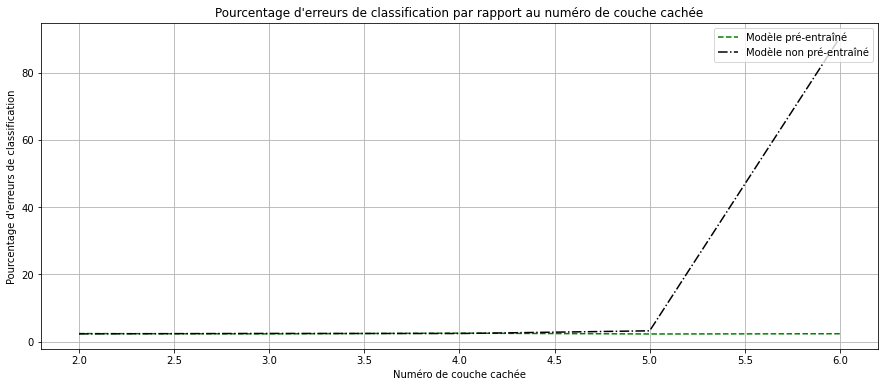

In [173]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(2,hidden_mult+1)], test_pretrain, '--g', label='Modèle pré-entraîné') # dashed cyan
plt.plot([i for i in range(2,hidden_mult+1)], test_retro, '-.k', label='Modèle non pré-entraîné') # dashdot black
plt.grid()
plt.legend(loc="upper right")
plt.title('Pourcentage d\'erreurs de classification par rapport au numéro de couche cachée');
plt.xlabel('Numéro de couche cachée')
plt.ylabel('Pourcentage d\'erreurs de classification');

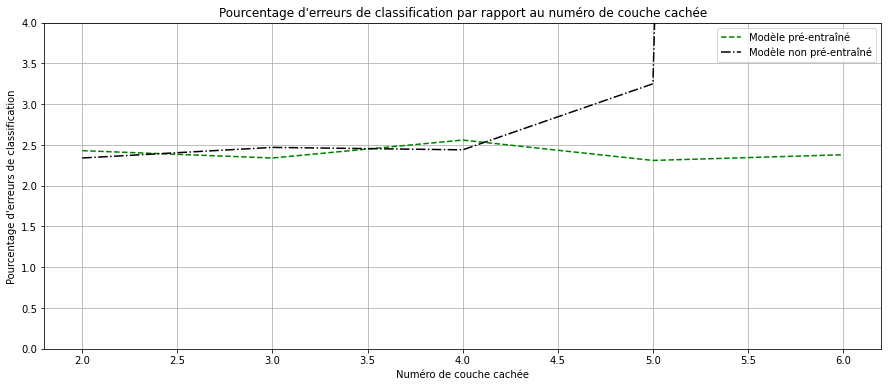

In [174]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(2,hidden_mult+1)], test_pretrain, '--g', label='Modèle pré-entraîné') # dashed cyan
plt.plot([i for i in range(2,hidden_mult+1)], test_retro, '-.k', label='Modèle non pré-entraîné') # dashdot black
plt.ylim(0,4)
plt.grid()
plt.legend(loc="upper right")
plt.title('Pourcentage d\'erreurs de classification par rapport au numéro de couche cachée');
plt.xlabel('Numéro de couche cachée')
plt.ylabel('Pourcentage d\'erreurs de classification');

### L'effet du nombre de neurones de la couche cachée sur la classification

Dans cette expérience, nous considérerons deux DNN avec 2 couches cachées. Nous augmenterons progressivement le nombre de neurones avec les couches cachées de 200 à 700 neurones. Nous utilisons tous les 60000 échantillons de train.

In [176]:
hidden_mult = 7
layers_list = []
for i in range(2,hidden_mult+1):
    layers=[100, 100]
    for j in range(len(layers)):
        layers[j] *= i
    layers_list.append(layers)
for layers in layers_list:
    layers.insert(0, data_mnist[0, :].shape[0])
    layers.append(10)

In [179]:
test_pretrain_size, test_retro_size = [], []
for layer in layers_list:
    dnn_pretrain = MNIST_DNN(layer)
    dnn_retro = MNIST_DNN(layer)
    
    print('Training pretrained version')
    print('begin unsupervised training')
    dnn_pretrain = dnn_pretrain.pretrain_DNN(data_mnist, batch_size=150, n_epoch=15000)
    print('Unsupervised training is done')
    
    print('Begin supervised training')
    dnn_pretrain = dnn_pretrain.retropropagation(data_mnist, labels, lr_rate=0.1, batch_size=150, n_epoch=30000)
    print('Supervised training is done')
    
    print('Training non pretrained version')
    print('Begin supervised training')
    dnn_retro = dnn_retro.retropropagation(data_mnist, labels, lr_rate=0.1, batch_size=150, n_epoch=30000)
    print('Supervised training is done')
    
    test_pretrain_size.append(dnn_pretrain.test_dnn(test_data, y_test))
    test_retro_size.append(dnn_retro.test_dnn(test_data, y_test))

Training pretrained version
begin unsupervised training
Training layer  0
Iteration 0 out of 15000. Loss value is 374.6843
Iteration 1000 out of 15000. Loss value is 71.9917
Iteration 2000 out of 15000. Loss value is 62.7141
Iteration 3000 out of 15000. Loss value is 56.0124
Iteration 4000 out of 15000. Loss value is 53.8903
Iteration 5000 out of 15000. Loss value is 51.9466
Iteration 6000 out of 15000. Loss value is 49.8356
Iteration 7000 out of 15000. Loss value is 49.7280
Iteration 8000 out of 15000. Loss value is 49.9067
Iteration 9000 out of 15000. Loss value is 47.2757
Iteration 10000 out of 15000. Loss value is 47.2500
Iteration 11000 out of 15000. Loss value is 45.4798
Iteration 12000 out of 15000. Loss value is 43.2865
Iteration 13000 out of 15000. Loss value is 44.0042
Iteration 14000 out of 15000. Loss value is 44.7280
Training layer  1
Iteration 0 out of 15000. Loss value is 81.1422
Iteration 1000 out of 15000. Loss value is 40.0156
Iteration 2000 out of 15000. Loss value i

Unsupervised training is done
Begin supervised training
Iteration 0 out of 30000. CELoss value is 35.4381
Iteration 1000 out of 30000. CELoss value is 0.3532
Iteration 2000 out of 30000. CELoss value is 0.3236
Iteration 3000 out of 30000. CELoss value is 0.1706
Iteration 4000 out of 30000. CELoss value is 0.1883
Iteration 5000 out of 30000. CELoss value is 0.2125
Iteration 6000 out of 30000. CELoss value is 0.1216
Iteration 7000 out of 30000. CELoss value is 0.1464
Iteration 8000 out of 30000. CELoss value is 0.1356
Iteration 9000 out of 30000. CELoss value is 0.1090
Iteration 10000 out of 30000. CELoss value is 0.0895
Iteration 11000 out of 30000. CELoss value is 0.0839
Iteration 12000 out of 30000. CELoss value is 0.2334
Iteration 13000 out of 30000. CELoss value is 0.1658
Iteration 14000 out of 30000. CELoss value is 0.1198
Iteration 15000 out of 30000. CELoss value is 0.0840
Iteration 16000 out of 30000. CELoss value is 0.0509
Iteration 17000 out of 30000. CELoss value is 0.0436
It

Iteration 13000 out of 30000. CELoss value is 0.1572
Iteration 14000 out of 30000. CELoss value is 0.2892
Iteration 15000 out of 30000. CELoss value is 0.0871
Iteration 16000 out of 30000. CELoss value is 0.1811
Iteration 17000 out of 30000. CELoss value is 0.1001
Iteration 18000 out of 30000. CELoss value is 0.0677
Iteration 19000 out of 30000. CELoss value is 0.1051
Iteration 20000 out of 30000. CELoss value is 0.0681
Iteration 21000 out of 30000. CELoss value is 0.0764
Iteration 22000 out of 30000. CELoss value is 0.0622
Iteration 23000 out of 30000. CELoss value is 0.0820
Iteration 24000 out of 30000. CELoss value is 0.0742
Iteration 25000 out of 30000. CELoss value is 0.0655
Iteration 26000 out of 30000. CELoss value is 0.0336
Iteration 27000 out of 30000. CELoss value is 0.0219
Iteration 28000 out of 30000. CELoss value is 0.0811
Iteration 29000 out of 30000. CELoss value is 0.0481
Supervised training is done
The percentage of false labeled data is  2.25
The percentage of false l

Iteration 10000 out of 15000. Loss value is 77.3718
Iteration 11000 out of 15000. Loss value is 75.1101
Iteration 12000 out of 15000. Loss value is 75.7841
Iteration 13000 out of 15000. Loss value is 74.9238
Iteration 14000 out of 15000. Loss value is 72.7695
Training layer  2
Iteration 0 out of 15000. Loss value is 279.7001
Iteration 1000 out of 15000. Loss value is 87.5230
Iteration 2000 out of 15000. Loss value is 82.4902
Iteration 3000 out of 15000. Loss value is 78.0735
Iteration 4000 out of 15000. Loss value is 78.5143
Iteration 5000 out of 15000. Loss value is 72.1363
Iteration 6000 out of 15000. Loss value is 72.3094
Iteration 7000 out of 15000. Loss value is 70.4687
Iteration 8000 out of 15000. Loss value is 68.3149
Iteration 9000 out of 15000. Loss value is 68.4301
Iteration 10000 out of 15000. Loss value is 66.4552
Iteration 11000 out of 15000. Loss value is 68.4318
Iteration 12000 out of 15000. Loss value is 67.3520
Iteration 13000 out of 15000. Loss value is 63.4313
Iterat

Iteration 24000 out of 30000. CELoss value is 0.0951
Iteration 25000 out of 30000. CELoss value is 0.1428
Iteration 26000 out of 30000. CELoss value is 0.0503
Iteration 27000 out of 30000. CELoss value is 0.0536
Iteration 28000 out of 30000. CELoss value is 0.0489
Iteration 29000 out of 30000. CELoss value is 0.0519
Supervised training is done
Training non pretrained version
Begin supervised training
Iteration 0 out of 30000. CELoss value is 2.8925
Iteration 1000 out of 30000. CELoss value is 0.7815
Iteration 2000 out of 30000. CELoss value is 0.7178
Iteration 3000 out of 30000. CELoss value is 0.2275
Iteration 4000 out of 30000. CELoss value is 0.1957
Iteration 5000 out of 30000. CELoss value is 0.5899
Iteration 6000 out of 30000. CELoss value is 0.2430
Iteration 7000 out of 30000. CELoss value is 0.2314
Iteration 8000 out of 30000. CELoss value is 0.1747
Iteration 9000 out of 30000. CELoss value is 0.1043
Iteration 10000 out of 30000. CELoss value is 0.3385
Iteration 11000 out of 300

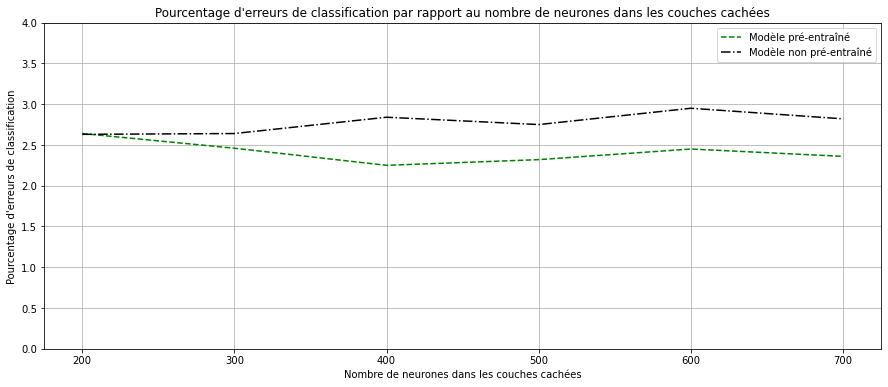

In [181]:
plt.figure(figsize=(15,6))
plt.plot([100*i for i in range(2,hidden_mult+1)], test_pretrain_size, '--g', label='Modèle pré-entraîné') # dashed cyan
plt.plot([100*i for i in range(2,hidden_mult+1)], test_retro_size, '-.k', label='Modèle non pré-entraîné') # dashdot black
plt.ylim(0,4)
plt.grid()
plt.legend(loc="upper right")
plt.title('Pourcentage d\'erreurs de classification par rapport au nombre de neurones dans les couches cachées');
plt.xlabel('Nombre de neurones dans les couches cachées')
plt.ylabel('Pourcentage d\'erreurs de classification');

### L'effet du L'effet du nombre d'échantillons d'apprentissage sur l'erreur de classification

Dans cette expérience, nous prenons deux réseaux de même taille avec deux couches cachées de taille 200. Nous entraînons ensuite chacun, le pré-entraîné et le régulier, sur des ensembles de données de tailles croissantes, allant de 1000 à 60000.

In [186]:
sizes = [1000, 3000, 7000, 10000, 30000, 6000]
data_list = []
labels_list = []
layers = [data_mnist[0, :].shape[0], 200, 200, 10]
for size in sizes:
    idx = np.random.choice(np.arange(data_mnist.shape[0]), size)
    data_sample = data[idx]
    labels_sample = labels[idx]
    data_list.append(data_sample)
    labels_list.append(labels_sample)
labels_list.append(labels)
data_list.append(data_mnist)

In [188]:
test_pretrain_data, test_retro_data = [], []
for i in range(len(sizes)):
    dnn_pretrain = MNIST_DNN(layers)
    dnn_retro = MNIST_DNN(layers)
    
    print('Training pretrained version')
    print('begin unsupervised training')
    dnn_pretrain = dnn_pretrain.pretrain_DNN(data_list[i], batch_size=150, n_epoch=15000)
    print('Unsupervised training is done')
    
    print('Begin supervised training')
    dnn_pretrain = dnn_pretrain.retropropagation(data_list[i], labels_list[i], lr_rate=0.1, batch_size=150, n_epoch=30000)
    print('Supervised training is done')
    
    print('Training non pretrained version')
    print('Begin supervised training')
    dnn_retro = dnn_retro.retropropagation(data_list[i], labels_list[i], lr_rate=0.1, batch_size=150, n_epoch=30000)
    print('Supervised training is done')
    
    test_pretrain_data.append(dnn_pretrain.test_dnn(test_data, y_test))
    test_retro_data.append(dnn_retro.test_dnn(test_data, y_test))

Training pretrained version
begin unsupervised training
Training layer  0
Iteration 0 out of 15000. Loss value is 375.7275
Iteration 1000 out of 15000. Loss value is 70.9831
Iteration 2000 out of 15000. Loss value is 62.8446
Iteration 3000 out of 15000. Loss value is 52.5801
Iteration 4000 out of 15000. Loss value is 51.6788
Iteration 5000 out of 15000. Loss value is 47.8698
Iteration 6000 out of 15000. Loss value is 49.0965
Iteration 7000 out of 15000. Loss value is 44.2433
Iteration 8000 out of 15000. Loss value is 43.7341
Iteration 9000 out of 15000. Loss value is 43.5042
Iteration 10000 out of 15000. Loss value is 40.1347
Iteration 11000 out of 15000. Loss value is 39.1886
Iteration 12000 out of 15000. Loss value is 39.0707
Iteration 13000 out of 15000. Loss value is 38.4562
Iteration 14000 out of 15000. Loss value is 36.4885
Training layer  1
Iteration 0 out of 15000. Loss value is 83.5395
Iteration 1000 out of 15000. Loss value is 41.1769
Iteration 2000 out of 15000. Loss value i

Unsupervised training is done
Begin supervised training
Iteration 0 out of 30000. CELoss value is 30.0953
Iteration 1000 out of 30000. CELoss value is 0.3536
Iteration 2000 out of 30000. CELoss value is 0.1538
Iteration 3000 out of 30000. CELoss value is 0.1319
Iteration 4000 out of 30000. CELoss value is 0.0880
Iteration 5000 out of 30000. CELoss value is 0.0734
Iteration 6000 out of 30000. CELoss value is 0.0318
Iteration 7000 out of 30000. CELoss value is 0.0462
Iteration 8000 out of 30000. CELoss value is 0.0417
Iteration 9000 out of 30000. CELoss value is 0.0268
Iteration 10000 out of 30000. CELoss value is 0.0240
Iteration 11000 out of 30000. CELoss value is 0.0192
Iteration 12000 out of 30000. CELoss value is 0.0160
Iteration 13000 out of 30000. CELoss value is 0.0122
Iteration 14000 out of 30000. CELoss value is 0.0106
Iteration 15000 out of 30000. CELoss value is 0.0156
Iteration 16000 out of 30000. CELoss value is 0.0140
Iteration 17000 out of 30000. CELoss value is 0.0084
It

Iteration 13000 out of 30000. CELoss value is 0.0427
Iteration 14000 out of 30000. CELoss value is 0.0453
Iteration 15000 out of 30000. CELoss value is 0.0297
Iteration 16000 out of 30000. CELoss value is 0.0384
Iteration 17000 out of 30000. CELoss value is 0.0376
Iteration 18000 out of 30000. CELoss value is 0.0101
Iteration 19000 out of 30000. CELoss value is 0.0274
Iteration 20000 out of 30000. CELoss value is 0.0206
Iteration 21000 out of 30000. CELoss value is 0.0220
Iteration 22000 out of 30000. CELoss value is 0.0078
Iteration 23000 out of 30000. CELoss value is 0.0177
Iteration 24000 out of 30000. CELoss value is 0.0098
Iteration 25000 out of 30000. CELoss value is 0.0181
Iteration 26000 out of 30000. CELoss value is 0.0131
Iteration 27000 out of 30000. CELoss value is 0.0106
Iteration 28000 out of 30000. CELoss value is 0.0080
Iteration 29000 out of 30000. CELoss value is 0.0055
Supervised training is done
The percentage of false labeled data is  4.45
The percentage of false l

Iteration 10000 out of 15000. Loss value is 26.4443
Iteration 11000 out of 15000. Loss value is 26.0024
Iteration 12000 out of 15000. Loss value is 25.1057
Iteration 13000 out of 15000. Loss value is 24.8293
Iteration 14000 out of 15000. Loss value is 24.5155
Training layer  2
Iteration 0 out of 15000. Loss value is 83.7407
Iteration 1000 out of 15000. Loss value is 54.2470
Iteration 2000 out of 15000. Loss value is 51.1915
Iteration 3000 out of 15000. Loss value is 47.6970
Iteration 4000 out of 15000. Loss value is 46.2700
Iteration 5000 out of 15000. Loss value is 44.0266
Iteration 6000 out of 15000. Loss value is 43.2642
Iteration 7000 out of 15000. Loss value is 41.3890
Iteration 8000 out of 15000. Loss value is 41.6117
Iteration 9000 out of 15000. Loss value is 40.9408
Iteration 10000 out of 15000. Loss value is 38.5384
Iteration 11000 out of 15000. Loss value is 39.5206
Iteration 12000 out of 15000. Loss value is 37.9235
Iteration 13000 out of 15000. Loss value is 38.8441
Iterati

In [191]:
dnn_pretrain = MNIST_DNN(layers)
dnn_retro = MNIST_DNN(layers)

print('Training pretrained version')
print('begin unsupervised training')
dnn_pretrain = dnn_pretrain.pretrain_DNN(data_list[-1], batch_size=150, n_epoch=15000)
print('Unsupervised training is done')

print('Begin supervised training')
dnn_pretrain = dnn_pretrain.retropropagation(data_list[-1], labels_list[-1], lr_rate=0.1, batch_size=150, n_epoch=30000)
print('Supervised training is done')

print('Training non pretrained version')
print('Begin supervised training')
dnn_retro = dnn_retro.retropropagation(data_list[-1], labels_list[-1], lr_rate=0.1, batch_size=150, n_epoch=30000)
print('Supervised training is done')

test_pretrain_data.append(dnn_pretrain.test_dnn(test_data, y_test))
test_retro_data.append(dnn_retro.test_dnn(test_data, y_test))

Training pretrained version
begin unsupervised training
Training layer  0
Iteration 0 out of 15000. Loss value is 379.7778
Iteration 1000 out of 15000. Loss value is 74.1832
Iteration 2000 out of 15000. Loss value is 63.2053
Iteration 3000 out of 15000. Loss value is 59.0773
Iteration 4000 out of 15000. Loss value is 53.4213
Iteration 5000 out of 15000. Loss value is 52.9110
Iteration 6000 out of 15000. Loss value is 53.2872
Iteration 7000 out of 15000. Loss value is 49.3080
Iteration 8000 out of 15000. Loss value is 48.4353
Iteration 9000 out of 15000. Loss value is 46.7265
Iteration 10000 out of 15000. Loss value is 46.0705
Iteration 11000 out of 15000. Loss value is 45.7500
Iteration 12000 out of 15000. Loss value is 43.7109
Iteration 13000 out of 15000. Loss value is 46.9493
Iteration 14000 out of 15000. Loss value is 43.8780
Training layer  1
Iteration 0 out of 15000. Loss value is 81.9111
Iteration 1000 out of 15000. Loss value is 40.4514
Iteration 2000 out of 15000. Loss value i

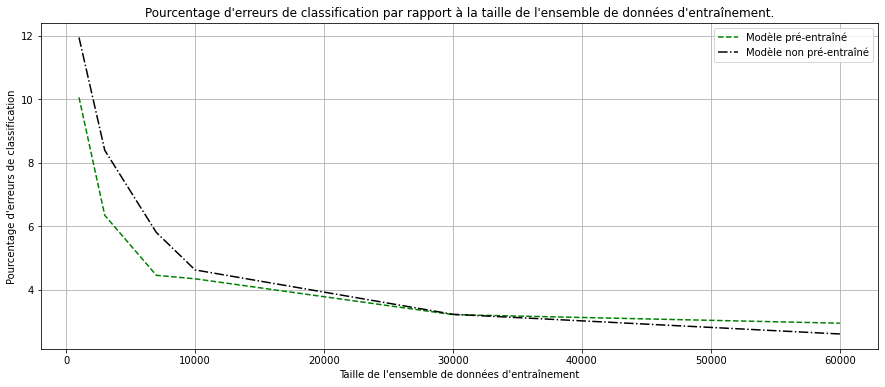

In [195]:
sizes.append(60000)
plt.figure(figsize=(15,6))
plt.plot(sizes, test_pretrain_data, '--g', label='Modèle pré-entraîné') # dashed cyan
plt.plot(sizes, test_retro_data, '-.k', label='Modèle non pré-entraîné') # dashdot black
plt.grid()
plt.legend(loc="upper right")
plt.title('Pourcentage d\'erreurs de classification par rapport à la taille de l\'ensemble de données d\'entraînement.');
plt.xlabel('Taille de l\'ensemble de données d\'entraînement')
plt.ylabel('Pourcentage d\'erreurs de classification');

### Bonne architecture de classification: 
Pour la tâche de classification, le réseau pré-entraîné que nous avons généré avec les images, avec des couches qui sont $[784, 600, 500, 400, 300, 200, 100, 50, 10]$ et avec toutes les données d'apprentissage, a donné un bon résultat avec 97,5% de données correctement étiquetées. Il a également généré des images comme celle fournie. Nous considérons donc cette architecture comme la seule à utiliser pour un bon score de classification. Cependant, nous avons remarqué que les petites architectures, pré-entraîné ou non, donnaient aussi de bons résultats comme celle avec les couches suivantes $[784, 200, 200, 10]$. Nous notons que nous n'avons pas étudié la capacité de génération de cette architecture.